In [1]:
import sys
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
import math as m
import argparse
from astropy.cosmology import FlatLambdaCDM
from matplotlib.backends.backend_pdf import PdfPages
import kcorrect
import kcorrect.utils as ut
import os
import pandas as pd

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("filein",help="File containing magnitudes and redshifts")
parser.add_argument("-mbin","--mbin",type=int,help="Number of Absolute Magnitude bins. Default=19",default=18)
parser.add_argument("-zmin","--zmin",type=float,help="Minimum redshift to consider in luminosity function, default=0.01", default=0.01)
parser.add_argument("-zmax","--zmax",type=float,help="Maximum redshift to consider in luminosity function, default=2", default=0.2)
parser.add_argument("-mmin","--Mmin",type=float,help="Minumum absolute magnitude to consider in luminosity function, default=-24", default=-24)
parser.add_argument("-mmax","--Mmax",type=float,help="Maximum absolute magnitude to consider in luminosity function, default=-15", default=-15)
parser.add_argument("-ama","--appmax",type=float,help='Maximum apparent magnitude to consider part of the survey COSMOS i<22.5',default=22.5)
parser.add_argument("-ami","--appmin",type=float,help='Minimum apparent magnitude to consider part of the survey COSMOS i>15',default=15)
parser.add_argument("-om","--OmegaMatter",type=float,help="Omega Matter, if you want to define your own cosmology", default=0.3)
parser.add_argument("-ho","--HubbleConstant",type=float,help="Hubble Constant if you want to define your own cosmology",default=70)
parser.add_argument("-lfdir","--lfdir",help="Directroy you want to put the Luminosity Function txt file and the underlying catalog in",default='/Users/lucashunt/projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT/')
parser.add_argument("-fileout","--fileout",type=str,help="Set a string if you want to give a filename if not it will default to LF_zmin_zmax.csv",default='')
parser.add_argument("-LCBG","--LCBGLIST",action="store_true",help="Make Luminosity Function with LCBGs only?")
parser.add_argument("-nv","--novega",action="store_true",help="Do not apply correction to switch from AB to Vega magnitudes")
args=parser.parse_args()

usage: ipykernel_launcher.py [-h] [-mbin MBIN] [-zmin ZMIN] [-zmax ZMAX]
                             [-mmin MMIN] [-mmax MMAX] [-ama APPMAX]
                             [-ami APPMIN] [-om OMEGAMATTER]
                             [-ho HUBBLECONSTANT] [-lfdir LFDIR]
                             [-fileout FILEOUT] [-LCBG] [-nv]
                             filein
ipykernel_launcher.py: error: the following arguments are required: filein


SystemExit: 2

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3273: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
#This can be turned to code in a jupyter notebook to set all of the args using argparser. That way you can run the code in the notebook

args=parser.parse_args('/Users/lucashunt/ASTRODATA/LCBG_LUMINOSITY_FUNCTION/COSMOS_CATALOGS/Photometry/COSMOS_CONVERTED_CATALOG.csv -zmin 0.01 -zmax 0.2'.split())

Setting values needed throughout the code

In [4]:
cosmo=FlatLambdaCDM(H0=args.HubbleConstant,Om0=args.OmegaMatter)
mbinsize=float(args.Mmax-args.Mmin)/args.mbin
Magnitude_Loop_Array=np.stack((np.arange(args.appmin,args.appmax+0.5,0.5)[0:len(np.arange(args.appmin,args.appmax+0.5,0.5))-1],np.arange(args.appmin,args.appmax+0.5,0.5)[1:len(np.arange(args.appmin,args.appmax+0.5,0.5))]),axis=-1)
kcordir=os.environ["KCORRECT_DIR"]

In [5]:
print('********READING FILE********')
CATALOG=pd.read_csv(args.filein)

********READING FILE********


In [6]:
print('********CALCULATING WEIGHTS********')
tf=open('weights.txt','w')
CATALOG['Spec_Weight']=np.nan
CATALOG['Color_Weight']=np.nan
CATALOG['Surface_Brightness_Weight']=np.nan
for magrange in Magnitude_Loop_Array:
    Num_Good_Spec=len(CATALOG[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0)&((CATALOG.Z_USE==1)|(CATALOG.Z_USE==2))])
    Num_Bad_Spec=len(CATALOG[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0)&((CATALOG.Z_USE==3)|(CATALOG.Z_USE==4))])
    Num_Good_Color=len(CATALOG[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0)&((CATALOG.mag_subaru_B<100)&(CATALOG.mag_subaru_V<100))])
    Num_Bad_Color=len(CATALOG[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0)&((CATALOG.mag_subaru_B>100)|(CATALOG.mag_subaru_V>100))])
    Num_Bad_Rh=len(CATALOG[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0)&(np.isnan(CATALOG.Rh))])
    Num_Good_Rh=len(CATALOG[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0)&(~np.isnan(CATALOG.Rh))])
    CATALOG.loc[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0),'Spec_Weight']=float(Num_Good_Spec+Num_Bad_Spec)/float(Num_Good_Spec)
    CATALOG.loc[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0),'Color_Weight']=float(Num_Good_Color+Num_Bad_Color)/float(Num_Good_Color)
    CATALOG.loc[(CATALOG.mag_subaru_i>magrange[0])&(CATALOG.mag_subaru_i<magrange[1])&(CATALOG.SG_MASTER==0),'Surface_Brightness_Weight']=float(Num_Good_Rh+Num_Bad_Rh)/float(Num_Good_Rh)
    

********CALCULATING WEIGHTS********


Comment below will allow you to plot weights if you want to look at them! 

plt.plot(CATALOG.mag_subaru_i,CATALOG.Spec_Weight*CATALOG.Color_Weight*CATALOG.Surface_Brightness_Weight,'.')
plt.figure()
plt.plot(CATALOG.mag_subaru_i,CATALOG.Spec_Weight,'.')
plt.figure()
plt.plot(CATALOG.mag_subaru_i,CATALOG.Color_Weight,'.')
plt.figure()
plt.plot(CATALOG.mag_subaru_i,CATALOG.Surface_Brightness_Weight,'.')

***********************************
Starting the Luminosity Function part of the code! 
***********************************

Breaking up the large catalog into a smaller one containing the sources over the correct redshift range and apparent magnitude range

In [7]:
if args.LCBGLIST:
    LUMFUNC_CATALOG=CATALOG[(CATALOG.Z_USE<3)&(CATALOG.mag_subaru_i<=args.appmax)&(CATALOG.mag_subaru_i>=args.appmin)&(CATALOG.SG_MASTER==0)&(CATALOG.Z_BEST>=args.zmin)&(CATALOG.Z_BEST<=args.zmax)&(CATALOG.is_LCBG==1)]
else:
    LUMFUNC_CATALOG=CATALOG[(CATALOG.Z_USE<3)&(CATALOG.mag_subaru_i<=args.appmax)&(CATALOG.mag_subaru_i>=args.appmin)&(CATALOG.SG_MASTER==0)&(CATALOG.Z_BEST>=args.zmin)&(CATALOG.Z_BEST<=args.zmax)]

Setting apparent magnitude limits to calculate the range over which this source would be detected. 

0
0.6136 1.0


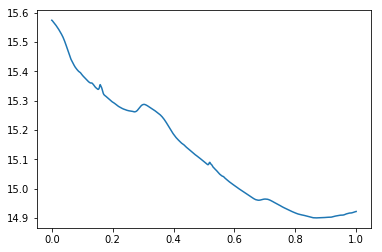

In [24]:
#The code below was designed to test the upper and lower redshift estimates. This allowed me to determine how the best order of operations to find the correct redshift limits for the source (Where the source was detectable)
x=35642
ilookup=np.ndarray(1000)
for j in range(0,1000):
    rmarrlookup[j]=kcorrect.reconstruct_maggies(LUMFUNC_CATALOG.loc[x,'c1':'c6'],redshift=zlookup[j])[1:]
print(np.abs(ilookup-args.appmax).argmin())
if np.abs(ilookup-args.appmax)[np.abs(ilookup-args.appmax).argsort()[:2][0]]<0.001:
    if np.abs(np.abs(ilookup-args.appmax).argsort()[:2][0]-np.abs(ilookup-args.appmax).argsort()[:2][1])>1:
        LUMFUNC_CATALOG.loc[x,'upper_redshift']=round(zlookup[np.abs(ilookup-args.appmax).argsort()[:2].min],4)
    else:
        LUMFUNC_CATALOG.loc[x,'upper_redshift']=round(zlookup[np.abs(ilookup-args.appmax).argmin()],4)
else:
    LUMFUNC_CATALOG.loc[x,'upper_redshift']=1
if np.abs(ilookup-args.appmin)[np.abs(ilookup-args.appmin).argsort()[:2][0]]<0.001:
    if np.abs(np.abs(ilookup-args.appmin).argsort()[:2][0]-np.abs(ilookup-args.appmin).argsort()[:2][1])>1:
        LUMFUNC_CATALOG.loc[x,'lower_redshift']=round(zlookup[np.abs(ilookup-args.appmin).argsort()[:2].min],4)
    else:
        LUMFUNC_CATALOG.loc[x,'lower_redshift']=round(zlookup[np.abs(ilookup-args.appmin).argmin()],4)
else:
    LUMFUNC_CATALOG.loc[x,'lower_redshift']=0
np.abs(ilookup-args.appmax).min()
print(LUMFUNC_CATALOG.lower_redshift.loc[x],LUMFUNC_CATALOG.upper_redshift.loc[x])
np.abs(np.abs(ilookup-args.appmax).argsort()[:2][0]-np.abs(ilookup-args.appmax).argsort()[:2][1])
plt.plot(zlookup,ilookup)
plt.
#np.abs(ilookup-args.appmax)[np.abs(ilookup-args.appmax).argsort()[:4]]

In [37]:
LUMFUNC_CATALOG.subaru_i_synthetic_mag.loc[x]

22.429613534928695

0.195195195195 0.1943 -17.347465152
The synthetic i-band is 22.474689281314987 and the measured i-band is 22.49369781006928


/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/astropy/cosmology/core.py:1363: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


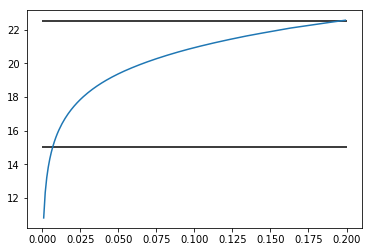

In [59]:
#The code below was designed to test the upper and lower redshift estimates. This allowed me to determine how the best order of operations to find the correct redshift limits for the source (Where the source was detectable)
x=77810
rmarrlookup=np.ndarray(1000)
for j in range(0,1000):
    rmarrlookup[j]=kcorrect.reconstruct_maggies(LUMFUNC_CATALOG.loc[x,'c1':'c6'],redshift=zlookup[j])[1:]
AbsMag=LUMFUNC_CATALOG.mag_subaru_i.loc[x]-cosmo.distmod(LUMFUNC_CATALOG.Z_BEST.loc[x]).value-LUMFUNC_CATALOG.subaru_i_synthetic_mag.loc[x]-2.5*np.log10(rmarrlookup[0])
ilookup=AbsMag+cosmo.distmod(zlookup).value-2.5*np.log10(rmarrlookup)+2.5*np.log10(rmarrlookup[0])
print(zlookup[round(np.abs(ilookup-args.appmax).argmin(),4)],LUMFUNC_CATALOG.Z_BEST.loc[x],AbsMag)
plt.plot(zlookup[0:200],ilookup[0:200])
plt.hlines(args.appmax,0,0.2)
plt.hlines(args.appmin,0,0.2)
print('The synthetic i-band is {} and the measured i-band is {}'.format(-2.5*np.log10(LUMFUNC_CATALOG.subaru_i0_synthetic.loc[x]),LUMFUNC_CATALOG.mag_subaru_i.loc[x]))

In [43]:
kcorrect.load_templates()
kcorrect.load_filters(kcordir+'/data/templates/subaru_i.dat')
zlookup=np.linspace(0,1,1000)
for x in LUMFUNC_CATALOG.index:
    rmarrlookup=np.ndarray(1000)
    for j in range(0,1000):
        rmarrlookup[j]=kcorrect.reconstruct_maggies(LUMFUNC_CATALOG.loc[x,'c1':'c6'],redshift=zlookup[j])[1:]
        AbsMag=LUMFUNC_CATALOG.mag_subaru_i.loc[x]-cosmo.distmod(LUMFUNC_CATALOG.Z_BEST.loc[x]).value-LUMFUNC_CATALOG.subaru_i_synthetic_mag.loc[x]-2.5*np.log10(rmarrlookup[0])
    ilookup=AbsMag+cosmo.distmod(zlookup).value-2.5*np.log10(rmarrlookup)+2.5*np.log10(rmarrlookup[0])
    LUMFUNC_CATALOG.loc[x,'upper_redshift']=round(zlookup[np.abs(ilookup-args.appmax).argmin()],4)
    LUMFUNC_CATALOG.loc[x,'lower_redshift']=round(zlookup[np.abs(ilookup-args.appmin).argmin()],4)
    #print('Lower redshift = {}, upper redshift = {} and spectroscopic redshift = {}'.format(LUMFUNC_CATALOG.lower_redshift.loc[x],LUMFUNC_CATALOG.upper_redshift.loc[x],LUMFUNC_CATALOG.Z_BEST.loc[x]))

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


          Z_BEST  upper_redshift
167762  0.121149          0.1211
168589  0.124144          0.1241
174061  0.030040          0.0300
175251  0.039040          0.0390


Series([], Name: upper_redshift, dtype: float64)

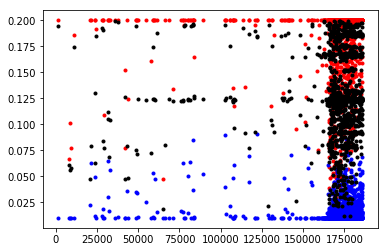

In [58]:
plt.plot(LUMFUNC_CATALOG.upper_redshift.loc[LUMFUNC_CATALOG.index],'.',color='red')
plt.plot(LUMFUNC_CATALOG.lower_redshift.loc[LUMFUNC_CATALOG.index],'.',color='blue')
plt.plot(LUMFUNC_CATALOG.Z_BEST,'.',color='black')
print(LUMFUNC_CATALOG.loc[LUMFUNC_CATALOG.Z_BEST>LUMFUNC_CATALOG.upper_redshift,['Z_BEST','upper_redshift']])
LUMFUNC_CATALOG.loc[LUMFUNC_CATALOG.upper_redshift<LUMFUNC_CATALOG.lower_redshift,'upper_redshift']

#This code was just used as fun to plot some of the lookup arrays to see how unique the values are (i.e. are there multiple crossings of the lookup table? Hint: There are not. You can uncomment this if you want to see a couple) 
#kcorrect.load_templates()
#kcorrect.load_filters(kcordir+'/data/templates/subaru_i.dat')
zlookup=np.linspace(0,1,1000)
print(LUMFUNC_CATALOG.loc[LUMFUNC_CATALOG.index[0],'c1':'c6'])
index=LUMFUNC_CATALOG.index
for x in range(40,60):
    rmarrlookup=np.ndarray(1000)
    for j in range(0,1000):
        rmarrlookup[j]=kcorrect.reconstruct_maggies(LUMFUNC_CATALOG.loc[index[x],'c1':'c6'],redshift=zlookup[j])[1:]
    app_mag_lookup=cosmo.distmod(zlookup).value-2.5*np.log10(rmarrlookup)
    plt.figure()
    plt.plot(zlookup,app_mag_lookup)
    plt.hlines(LUMFUNC_CATALOG.imag_upper_lim.loc[index[x]],0,1)
    plt.hlines(LUMFUNC_CATALOG.imag_lower_lim.loc[index[x]],0,1)

In [48]:
LUMFUNC_CATALOG_COPY=LUMFUNC_CATALOG.copy()
LUMFUNC_CATALOG.loc[LUMFUNC_CATALOG.upper_redshift>args.zmax,'upper_redshift']=args.zmax
LUMFUNC_CATALOG.loc[LUMFUNC_CATALOG.lower_redshift<args.zmin,'lower_redshift']=args.zmin
LUMFUNC_CATALOG['comoving_volume']=cosmo.comoving_volume(LUMFUNC_CATALOG.upper_redshift).value/(4*np.pi/0.0003116)-cosmo.comoving_volume(LUMFUNC_CATALOG.lower_redshift).value/(4*np.pi/0.0003116)

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [49]:
Abs_Magnitude_Loop_Array=np.stack((np.arange(args.Mmin,args.Mmax+mbinsize,mbinsize)[0:len(np.arange(args.Mmin,args.Mmax,mbinsize))],np.arange(args.Mmin,args.Mmax+mbinsize,mbinsize)[1:len(np.arange(args.Mmin,args.Mmax,mbinsize))+1]),axis=-1)
Abs_Mags=[]
NUMB_DENS_LIST=[]
NUMB_DENS_Err=[]
NGal=[]
AveCMV=[]
AveWeight=[]
for rng in Abs_Magnitude_Loop_Array:
    if args.LCBGLIST:
        NUMB_DENS_LIST.append(((LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Color_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Surface_Brightness_Weight'])/(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'comoving_volume']*mbinsize)).sum())
        AveWeight.append((LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Color_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Surface_Brightness_Weight']).sum()/len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']))
        NUMB_DENS_Err.append(np.sqrt(((LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Color_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Surface_Brightness_Weight'])/(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'comoving_volume']*mbinsize)**2).sum()))
    else:
        NUMB_DENS_LIST.append((LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']/(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'comoving_volume']*mbinsize)).sum())
        NUMB_DENS_Err.append(np.sqrt((LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']/(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'comoving_volume']*mbinsize)**2).sum()))
        AveWeight.append(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight'].sum()/len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']))
    NGal.append(len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']))
    AveCMV.append(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'comoving_volume'].sum()/len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']))
    Abs_Mags.append(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Abs_B_Mag'].mean())

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [50]:
(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Color_Weight']*LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Surface_Brightness_Weight']).sum()/len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.Abs_B_Mag>rng[0])&(LUMFUNC_CATALOG.Abs_B_Mag<rng[1]),'Spec_Weight'])

1.4388648148109731

In [51]:
Luminosity_Function=pd.DataFrame({'Number_Of_Gals':NGal,'Absolute_Magnitude_Bin':np.average(Abs_Magnitude_Loop_Array,axis=-1),'Average_Absolute_Magnitude':Abs_Mags,'Number_Density':NUMB_DENS_LIST,'Number_Density_Error':NUMB_DENS_Err,'Average_Comoving_Volume':AveCMV,'Average_Weight':AveWeight})

In [52]:
Luminosity_Function['Log10Phi']=np.log10(Luminosity_Function['Number_Density'])
Luminosity_Function['Log10Err']=Luminosity_Function.Number_Density_Error/(Luminosity_Function.Number_Density*np.log(10))

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


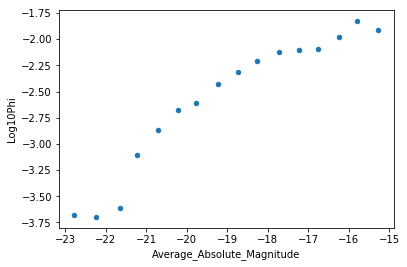

In [53]:
Luminosity_Function.plot.scatter(x='Average_Absolute_Magnitude',y='Log10Phi')

In [54]:
Luminosity_Function

,Absolute_Magnitude_Bin,Average_Absolute_Magnitude,Average_Comoving_Volume,Average_Weight,Number_Density,Number_Density_Error,Number_Of_Gals,Log10Phi,Log10Err
0,-23.75,NaN,NaN,NaN,0.000000,0.000000,0,-inf,NaN
1,-23.25,NaN,NaN,NaN,0.000000,0.000000,0,-inf,NaN
2,-22.75,-22.772321,54622.201875,5.750000,0.000211,0.000088,1,-3.676671,0.181113
3,-22.25,-22.233344,54800.480649,5.500000,0.000201,0.000086,1,-3.697392,0.185184
4,-21.75,-21.650996,51994.218200,1.050041,0.000242,0.000097,6,-3.615430,0.173059
5,-21.25,-21.218194,54338.980626,1.436025,0.000787,0.000170,15,-3.103821,0.093592
6,-20.75,-20.702192,55463.190294,1.301214,0.001359,0.000221,29,-2.866654,0.070701
7,-20.25,-20.225127,55989.533196,1.159435,0.002112,0.000275,51,-2.675316,0.056478
8,-19.75,-19.767604,56251.590329,1.178844,0.002473,0.000297,59,-2.606809,0.052075
9,-19.25,-19.238825,56445.021600,1.203459,0.003710,0.000363,87,-2.430644,0.042443


In [55]:
if args.LCBGLIST:
    Luminosity_Function.to_csv(args.lfdir+'LF_{}_{}_LCBG.csv'.format(int(args.zmin*100),int(args.zmax*100)))
else:
    Luminosity_Function.to_csv(args.lfdir+'LF_{}_{}.csv'.format(int(args.zmin*100),int(args.zmax*100)))

In [236]:
sum(Luminosity_Function.Number_Of_Gals)

4034